In [ ]:
import numpy as np

eval_data_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_data_complete.npy")
eval_label_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_label_complete.npy")

In [ ]:
eval_data = eval_data_original[10:-50]
eval_label = eval_label_original[10:-50]

test_data = np.concatenate((eval_data_original[:10], eval_data_original[-50:]))
test_label = np.concatenate((eval_label_original[:10], eval_label_original[-50:]))

eval_data_original = 0
eval_label_original = 0

In [ ]:
eval_data = np.concatenate((eval_data[:337], eval_data[:337], eval_data[:337], eval_data[:337], eval_data))
eval_label = np.concatenate((eval_label[:337], eval_label[:337], eval_label[:337], eval_label[:337], eval_label))
print(eval_data.shape)
print(eval_label.shape)

(3483, 22, 15000)
(3483,)


In [ ]:
idx = np.random.permutation(len(eval_data))
eval_data,eval_label = eval_data[idx], eval_label[idx]
idx = 0

In [ ]:
from tensorflow.keras.utils import to_categorical

enc_labels = to_categorical(eval_label, num_classes=2)              
eval_label= enc_labels
enc_labels = 0
print(eval_data.shape)
print(eval_label.shape)
print(eval_data.dtype)
print(eval_label.dtype)
print('training labels have been loaded')

bs,t,f = eval_data.shape

(3483, 22, 15000)
(3483, 2)
float32
float32
training labels have been loaded


In [ ]:
from pdb import set_trace
#import mne
import pandas as pd
import numpy as np
import math
import os
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM, Dense, Activation, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


# ----------------------DEEP-NET Testing-----------------------
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,Conv2D
from tensorflow.keras.models import Model

inputsin= Input(shape=(t,f))


# ------------------First Inception
deep_net = Conv1D(25, 10, strides=1, activation='relu',padding="causal")(inputsin)
deep_net = MaxPooling1D(3, 3, padding="same")(deep_net)

deep_net = Conv1D(50, 10, activation='relu', padding='causal')(deep_net)
deep_net = MaxPooling1D(3, 3, padding='same')(deep_net)

deep_net = Conv1D(100, 10, activation='relu', padding='causal')(deep_net)
deep_net = MaxPooling1D(3, 3, padding='same')(deep_net)

deep_net = Conv1D(200, 10, activation='relu', padding='causal')(deep_net)
deep_net = MaxPooling1D(3, 3, padding='same')(deep_net)

deep_net = Flatten()(deep_net)
predictions = Dense(2,activation='softmax')(deep_net)


deep_model = Model(inputs=inputsin, outputs=predictions)

# learning rate to 0.00001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

deep_model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
print(deep_model.metrics_names)
print(deep_model.summary())

# early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0.01, mode='min', verbose=1, patience=25)                                # patience
mc = ModelCheckpoint('deep_model3flipped_acc.hdf5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)        # filepath (save model as)
mces = ModelCheckpoint('deep_model3flipped_loss.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)    # filepath (save model as)

# fit model
hist=deep_model.fit(eval_data,eval_label,validation_split=0.1, epochs=100,batch_size=64,verbose=1,callbacks=[es, mc,mces],shuffle=False) #epochs #split #
print('The End')

[]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 15000)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 25)            3750025   
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 25)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 50)             12550     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 50)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 100)            50100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 100)            0  

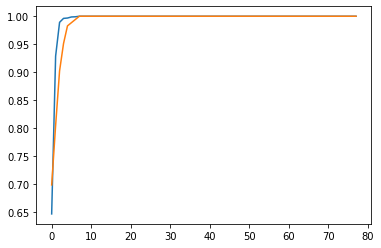

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

In [ ]:
predictions = Dense(2,activation='softmax')(deep_net)
model_2 = Model(inputs=inputsin, outputs=predictions)

model_2.load_weights("deep_model3flipped_loss.hdf5")

In [ ]:
pre = deep_model.predict(test_data)
pre_2 = model_2.predict(test_data)

In [ ]:
res = []
for p in pre:
  if p[0] > p[1]:
    res.append([0, 1])
  else:
    res.append([1, 0])

res_2 = []
for p in pre_2:
  if p[0] > p[1]:
    res_2.append([0, 1])
  else:
    res_2.append([1, 0])

In [ ]:
corr = 0
for i in range(len(test_label)):
  #print(int(test_label[i]), res[i])
  if res[i][int(test_label[i])] == 1:
    #print('yes')
    corr += 1
print(corr)

10


In [ ]:
corr = 0
for i in range(len(test_label)):
  #print(int(test_label[i]), res[i])
  if res_2[i][int(test_label[i])] == 1:
    #print('yes')
    corr += 1
print(corr)

10


In [ ]:
res = []
for p in pre:
  if p[1] < 0.025:
    res.append([1, 0])
  else:
    res.append([0, 1])

res_2 = []
for p in pre_2:
  if p[1] < 0.025:
    res_2.append([1, 0])
  else:
    res_2.append([0, 1])

In [ ]:
corr = 0
for i in range(len(test_label)):
  #print(int(test_label[i]), res[i])
  if res[i][int(test_label[i])] == 1:
    #print('yes')
    corr += 1
print(corr)

corr = 0
for i in range(len(test_label)):
  #print(int(test_label[i]), res[i])
  if res_2[i][int(test_label[i])] == 1:
    #print('yes')
    corr += 1
print(corr)

43
43


# 4 bit quantization

In [ ]:
! pip uninstall -y tensorflow
! pip install -q tf-nightly
! pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

import tempfile

In [ ]:
LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer

class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    # Configure how to quantize weights.
    def get_weights_and_quantizers(self, layer):
      return [(layer.kernel, LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

    # Configure how to quantize activations.
    def get_activations_and_quantizers(self, layer):
      return [(layer.activation, MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False))]

    def set_quantize_weights(self, layer, quantize_weights):
      # Add this line for each item returned in `get_weights_and_quantizers`
      # , in the same order
      layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
      # Add this line for each item returned in `get_activations_and_quantizers`
      # , in the same order.
      layer.activation = quantize_activations[0]

    # Configure how to quantize outputs (may be equivalent to activations).
    def get_output_quantizers(self, layer):
      return []

    def get_config(self):
      return {}

In [ ]:
class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):
    # Configure weights to quantize with 4-bit instead of 8-bits.
    def get_weights_and_quantizers(self, layer):
      return [(layer.kernel, MovingAverageQuantizer(num_bits=4, symmetric=True, narrow_range=False, per_axis=False))]
    
    
    def get_activations_and_quantizers(self, layer):
      return [(layer.activation, MovingAverageQuantizer(num_bits=4, symmetric=False, narrow_range=False, per_axis=False))]


In [ ]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope


In [ ]:
from pdb import set_trace
#import mne
import pandas as pd
import numpy as np
import math
import os
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM, Dense, Activation, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


# ----------------------DEEP-NET Testing-----------------------
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,Conv2D
from tensorflow.keras.models import Model


# Making a deep net


inputsin= Input(shape=(t,f))


# ------------------First Inception
deep_net = Conv1D(25, 10, strides=1, activation='relu',padding="causal")(inputsin)
deep_net = MaxPooling1D(3, 3, padding="same")(deep_net)

deep_net = Conv1D(50, 10, activation='relu', padding='causal')(deep_net)
deep_net = MaxPooling1D(3, 3, padding='same')(deep_net)

deep_net = Conv1D(100, 10, activation='relu', padding='causal')(deep_net)
deep_net = MaxPooling1D(3, 3, padding='same')(deep_net)

deep_net = Conv1D(200, 10, activation='relu', padding='causal')(deep_net)
deep_net = MaxPooling1D(3, 3, padding='same')(deep_net)

deep_net = Flatten()(deep_net)
predictions = Dense(2,activation='softmax')(deep_net)


deep_model = Model(inputs=inputsin, outputs=predictions)

# compiling model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
deep_model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])



# early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0.01, mode='min', verbose=1, patience=25)                                # patience
mc = ModelCheckpoint('deep_model3flipped_acc.hdf5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)        # filepath (save model as)
mces = ModelCheckpoint('deep_model3flipped_loss.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)    # filepath (save model as)

deep_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 22, 15000)]       0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 22, 25)            3750025   
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 8, 25)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 50)             12550     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 50)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3, 100)            50100     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 100)            0   

In [ ]:
# Helper function uses `quantize_annotate_layer` to annotate that only the 
# Dense layers should be quantized.
def apply_quantization(layer):
  if isinstance(layer, tf.keras.layers.Dense) or isinstance(layer, tf.keras.layers.Conv1D):
    return tfmot.quantization.keras.quantize_annotate_layer(layer, ModifiedDenseQuantizeConfig())
  return layer

annotated_model = tf.keras.models.clone_model(
    deep_model,
    clone_function=apply_quantization,
)

In [ ]:
with quantize_scope(
  {'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}):
  # Use `quantize_apply` to actually make the model quantization aware.
  quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 22, 15000)]       0         
_________________________________________________________________
quantize_layer (QuantizeLaye (None, 22, 15000)         3         
_________________________________________________________________
quant_conv1d_4 (QuantizeWrap (None, 22, 25)            3750030   
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 8, 25)             0         
_________________________________________________________________
quant_conv1d_5 (QuantizeWrap (None, 8, 50)             12555     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 50)             0         
_________________________________________________________________
quant_conv1d_6 (QuantizeWrap (None, 3, 100)            5010

In [ ]:
# learning rate to 0.00001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

quant_aware_model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
print(quant_aware_model.metrics_names)
print(quant_aware_model.summary())

# fit model
hist=quant_aware_model.fit(eval_data,eval_label,validation_split=0.1, epochs=100,batch_size=64,verbose=1,callbacks=[es, mc,mces],shuffle=False) #epochs #split #
print('The End')

[]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 22, 15000)]       0         
_________________________________________________________________
quantize_layer (QuantizeLaye (None, 22, 15000)         3         
_________________________________________________________________
quant_conv1d_4 (QuantizeWrap (None, 22, 25)            3750030   
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 8, 25)             0         
_________________________________________________________________
quant_conv1d_5 (QuantizeWrap (None, 8, 50)             12555     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 50)             0         
_________________________________________________________________
quant_conv1d_6 (QuantizeWrap (None, 3, 100)            5

In [ ]:
np.to_array(quant_aware_model.layers[2].weights[1].value)

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.plot(quant_aware_model.layers[2].weights[1].flatten())

AttributeError: ignored